In [11]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import json
import io
import time
import re
import sys
from pyspark import SparkConf, SparkContext
import findspark
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
def train_test_split(n = 0.7):
    time1 = time.time()
    # import files
    review_json_file = '/Users/wenxianfei/Desktop/lda_cf/review.json'

    review = []
    for line in open(review_json_file, 'r'):
        review.append(json.loads(line))

    # convert to dataframe
    review_df = pd.DataFrame.from_records(review)
    # extract the userful column
    review_df = review_df.loc[:,['business_id','user_id','stars','text']]
    # split the test and training dataset
    length = int(len(review_df) * n)

    review_df_training = review_df.iloc[:length,]
    review_df_test = review_df.iloc[length:,]
    review_df_training.to_csv('training.csv')
    review_df_test.to_csv('test.csv')
    time2 = time.time()
    print('SUCCESS!!!  train_test_split')
    print('The training set has ', length, 'rows data')
    print('The testing set has ', len(review_df) - length, 'rows data')
    print('Time: ', time2 - time1)

In [3]:
def textProcessing(text):
    # lower words  
    text = text.lower()
    # remove punctuation
    for c in string.punctuation:
        text = text.replace(c, ' ')
    # tokenize
    wordLst = nltk.word_tokenize(text)
    # stop word
    filtered = [w for w in wordLst if w not in stopwords.words('english')]
    # keep noun  
    refiltered =nltk.pos_tag(filtered)
    filtered = [w for w, pos in refiltered if pos.startswith('NN')]
    # xtract the stem
    ps = PorterStemmer()
    filtered = [ps.stem(w) for w in filtered]

    return " ".join(filtered) 

def rating_proportion(text,rate):
    return text * int(rate)

In [16]:
def lda_tfidf(review,n_topic = 10,n_top_words=20):
# vectorization
# generate the word-docu matrix
#     tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,stop_words='english')
#     word_count_vector = tf_vectorizer.fit_transform(review)
#     tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
#     tfidf_transformer.fit(word_count_vector)
#     tf_vectorizer = TfidfVectorizer()
#     count2 = tf_vectorizer.fit_transform()
# vectorization
# generate the word-docu matrix
    tf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english')
    tf = tf_vectorizer.fit_transform(review)
# train the lda model
    lda = LatentDirichletAllocation(n_topics=n_topic, 
                                max_iter=50,
                                learning_method='batch')
    lda.fit(tf)
# print the performance
    print('perplexity is: ',lda.perplexity(tf))

# generate the top word list for every topic
    tf_feature_names = tf_vectorizer.get_feature_names()
    feature_dict = {k: v for v, k in enumerate(tf_feature_names)}

#     for topic_idx, topic in enumerate(lda.components_):       
#         print ("Topic #%d:" % topic_idx)
#         print (" ".join([tf_feature_names[i]
#                         for i in topic.argsort()[:-n_top_words - 1:-1]]))    

# return the topic*word distribution matrix
    return lda.components_,feature_dict,lda.perplexity(tf)
    
    
def lda(review,n_topic = 10,n_top_words=20):
# vectorization
# generate the word-docu matrix
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,stop_words='english')
    tf = tf_vectorizer.fit_transform(review)
# train the lda model
    lda = LatentDirichletAllocation(n_topics=n_topic, 
                                max_iter=50,
                                learning_method='batch')
    lda.fit(tf)
# print the performance
    print('perplexity is: ',lda.perplexity(tf))

# generate the top word list for every topic
    tf_feature_names = tf_vectorizer.get_feature_names()
    feature_dict = {k: v for v, k in enumerate(tf_feature_names)}

#     for topic_idx, topic in enumerate(lda.components_):       
#         print ("Topic #%d:" % topic_idx)
#         print (" ".join([tf_feature_names[i]
#                         for i in topic.argsort()[:-n_top_words - 1:-1]]))    

# return the topic*word distribution matrix
    return lda.components_,feature_dict,lda.perplexity(tf)

In [5]:
train_test_split(n = 0.0001)

SUCCESS!!!  train_test_split
The training set has  668 rows data
The testing set has  6685232 rows data
Time:  270.80040192604065


In [6]:
training = pd.read_csv('training.csv')

In [7]:
training.head()

,Unnamed: 0,business_id,user_id,stars,text
0,0,ujmEBvifdJM6h6RLv4wQIg,hG7b0MtEbXx5QzbzE6C_VA,1.0,Total bill for this horrible service? Over $8G...
1,1,NZnhc2sEQy3RmzKTZnqtwQ,yXQM5uF2jS6es16SJzNHfg,5.0,I *adore* Travis at the Hard Rock's new Kelly ...
2,2,WTqjgwHlXbSFevF32_DJVw,n6-Gk65cPZL6Uz8qRm3NYw,5.0,I have to say that this office really has it t...
3,3,ikCg8xy5JIg_NGPx-MSIDA,dacAIZ6fTM6mqwW5uxkskg,5.0,Went in for a lunch. Steak sandwich was delici...
4,4,b1b1eb3uo-w561D0ZfCEiQ,ssoyf2_x0EQMed6fgHeMyQ,1.0,Today was my second out of three sessions I ha...


In [9]:
training['text'] = training['text'].apply(textProcessing)
training['text'] = training['text'] * training['stars'].apply(int)
review_by_user = training.groupby('user_id').text.sum()
review_by_business = training.groupby('business_id').text.sum()
review_by_user.to_csv('review_by_user.csv')
review_by_business.to_csv('review_by_business')

/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  11811.371223254107


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  14584.908690782813


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  16858.75537261738


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  18667.595864726714


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  20098.04955329583


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  25062.581605965544


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  29946.7488393383


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  30494.803978404638


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  36788.18674627017


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  42622.974999304344


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  40561.858823263814


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  48945.9499516601


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  60673.93784144008


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  62297.57751516476


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  81306.63207231149


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  82900.22724506864


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  85028.2498345725


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  86833.38269142126


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  95938.93291203452


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  112070.20982450548


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  133024.11957845904


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  118017.09504420316


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  142801.0301320106


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  145925.9580026213


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  181366.64928308027


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  168722.2641850576


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  161002.39424477858


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  230572.52129809235


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  233610.03334794717


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  221907.52647313743


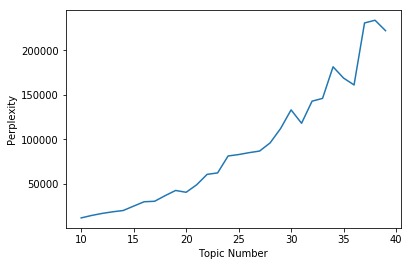

AttributeError: 'numpy.float64' object has no attribute 'index'

In [17]:
review = training['text'] 
topic_word_matrix_set = []
feature_dict_set = []
perplexity_set = []
# lda_set = []
for i in range(10,40):
    topic_word_matrix,feature_dict,perplexity = lda_tfidf(review,n_topic=i,n_top_words=20)
    topic_word_matrix_set.append(topic_word_matrix)
    feature_dict_set.append(feature_dict)
    perplexity_set.append(perplexity)
#     lda_set.append(lda)

plt.xlabel("Topic Number")
plt.ylabel("Perplexity")
plt.plot([i for i in range(10,40)],perplexity_set)
plt.show()

best_num_topic = perplexity.index(min(perplexity_set))
feature_dict = feature_dict_set[best_num_topic]
topic_word_matrix = topic_word_matrix_set[best_num_topic]